In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

2024-06-26 11:37:59.500432: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 11:37:59.504971: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 11:37:59.545478: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 11:38:00.164482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
df_train = pd.read_pickle("../hi_curves/hicurve.pkl")

SEQUENCE_LENGTH = 10
STEP_SIZE = 1
TRAIN_SIZE = 694 # idx gotten from empirically checking hi curve

# wil nu naar X y in de zin van:
# X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] y = [11] 
# X = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] y = [12]
# X = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12] y = [13]

def df_to_X_y(df, sequence_length=10):
    data = df.to_numpy()
    data = data.flatten() # --> shape from (len(df), 1) to (len(df),)
    
    X, y = [], []
    
    for i in range(len(data) - sequence_length):
        row = [[a] for a in data[i:i+sequence_length]]
        # row = [data[i:i+sequence_length]] # DIT WAS DE OUDE OFWEL [[1], [2], [3], [4], ETC] OF WEL [1, 2, 3, 4, ETC]
        X.append(row)
        
        label = data[i+sequence_length]
        y.append(label)

    return np.array(X), np.array(y)

X, y = df_to_X_y(df_train, SEQUENCE_LENGTH)
X.shape, y.shape

((974, 10, 1), (974,))

In [4]:
X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
X_test, y_test = X[TRAIN_SIZE:], y[TRAIN_SIZE:]

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((694, 10, 1), (694,), (280, 10, 1), (280,))

In [6]:
model = Sequential()
model.add(InputLayer(shape=(SEQUENCE_LENGTH, 1)))
model.add(Dense(5, activation='relu'))
model.add(Bidirectional(LSTM(30, return_sequences=False)))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear')) # HAS TO BE LINEAR

model.summary()

2024-06-26 11:38:01.789558: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10, 5)          │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60)             │         8,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           305 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,961 (35.00 KB)

 Trainable params: 8,961 (35.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# cp = ModelCheckpoint('model/', save_best_only=True) # WAT DOET DIT?
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [8]:
history = model.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.9068e-04 - root_mean_squared_error: 0.0216
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4980e-04 - root_mean_squared_error: 0.0122
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9897e-05 - root_mean_squared_error: 0.0070
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8400e-05 - root_mean_squared_error: 0.0043
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8629e-05 - root_mean_squared_error: 0.0043
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6534e-05 - root_mean_squared_error: 0.0041
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5246e-05 - root_mean_squared_error: 0.0039
Epoch 8/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4882e-05 - root_mean_squared_error: 0.0039
Epoch 9/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4662e-05 - root_mean_squared_error: 0.0038
Epoch 10/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - 

In [9]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})
train_results

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,Train Predictions,Actuals
0,-0.000243,0.000000
1,-0.000243,0.000014
2,-0.000236,0.000054
3,-0.000196,0.000115
4,-0.000084,0.000164
...,...,...
689,0.096781,0.094123
690,0.097188,0.094539
691,0.097780,0.094886
692,0.098110,0.099072


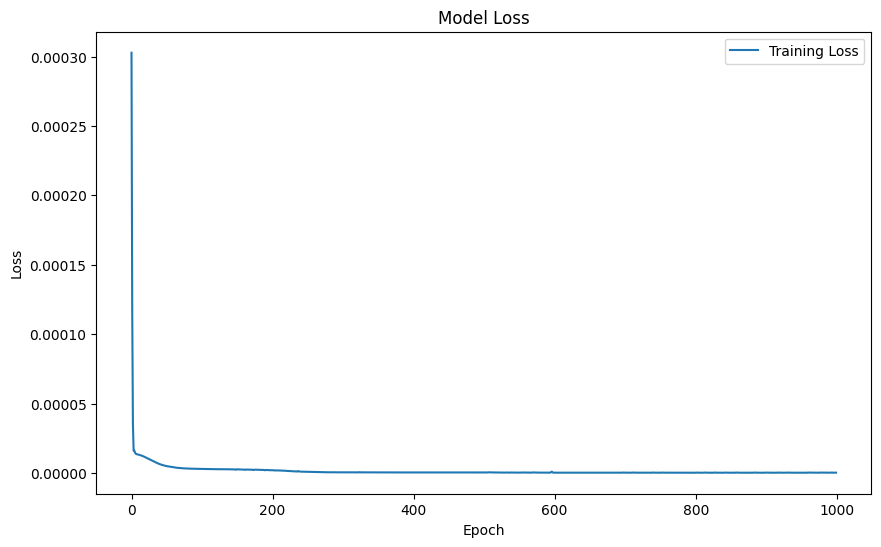

In [10]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

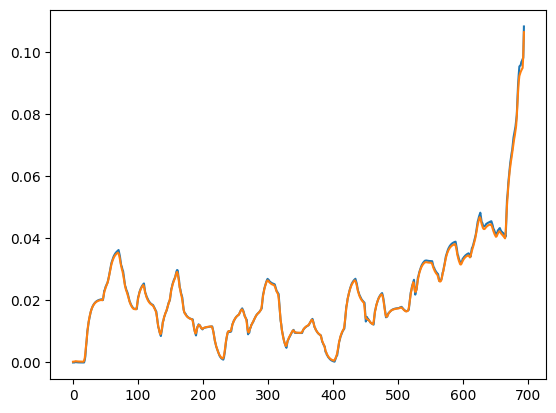

In [11]:
plt.plot(train_predictions)
plt.plot(y_train)
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


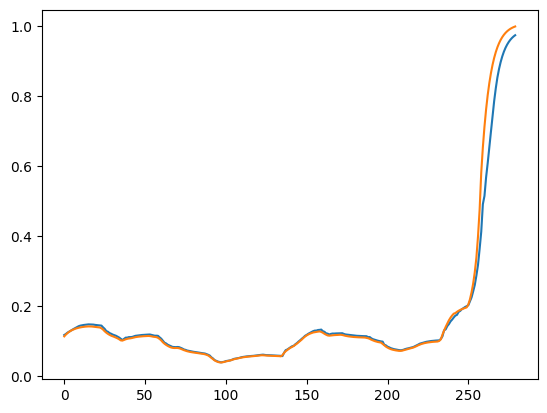

In [12]:
train_test = model.predict(X_test).flatten()
plt.plot(train_test)
plt.plot(y_test)
plt.show()

In [13]:
def error(rul_actual, rul_predicted, prediction_time):
    return (((rul_actual - prediction_time) - (rul_predicted - prediction_time)) / (rul_actual - prediction_time)) * 100

# TODO deze wordt vgm niet gebruikt
def find_failure(y):
    for n in range(len(y) - 100):
        if abs(y[n] - y[n+100]) <= 0.001:
            return n
    return -1 # return -1 if none found

def find_closest_to_one(y_values, test_starting_from=0):
    differences = [abs(y - 1) for y in y_values]
    closest_index = differences.index(min(differences))
    
    return closest_index + test_starting_from, y_values[closest_index]

def rul_in_minutes(rul_actual_idx, rul_pred_idx, pred_treshold, cycle_time_step_in_min):
    predicted_rul_min = (rul_pred_idx - pred_treshold) * cycle_time_step_in_min
    actual_rul_min = (rul_actual_idx - pred_treshold) * cycle_time_step_in_min

    return predicted_rul_min, actual_rul_min

rul_pred_idx, _ = find_closest_to_one(train_test, TRAIN_SIZE)
rul_actual_idx, _ = find_closest_to_one(df_train.to_numpy())

print(error(rul_actual_idx, rul_pred_idx, TRAIN_SIZE))

3.4602076124567476


In [14]:
def plot_test_preds_double_axis(test_df, test_starting_from, test_predictions, rul_pred_idx, rul_actual_idx, seconds_between_samples, out_string, zoom=False, xmin=None, xmax=None):
    fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))
    ax.plot(test_df, label='Actual HI curve')
    ax.plot(range(test_starting_from, test_starting_from + len(test_predictions)), test_predictions, color='orange', label='Predicted HI Curve')
    plt.axvline(x=test_starting_from, color='r', linestyle='--', linewidth=1)
    plt.axvline(x=rul_pred_idx, color='purple', linestyle='--', linewidth=1)
    plt.axvline(x=rul_actual_idx, color='green', linestyle='--', linewidth=1)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('HI value')
    ax.set_title('Actual vs Predicted HI Curve')
    
    def cycle2time(x):
        return x * seconds_between_samples / 60
    
    def time2cycle(x):
        return x * 60 / seconds_between_samples
    
    secax = ax.secondary_xaxis('top', functions=(cycle2time, time2cycle))
    secax.set_xlabel('Time (minutes)')
    plt.legend()
    plt.grid()

    if zoom:
        plt.xlim(xmin, xmax)
    
    plt.savefig(out_string)
    plt.show()

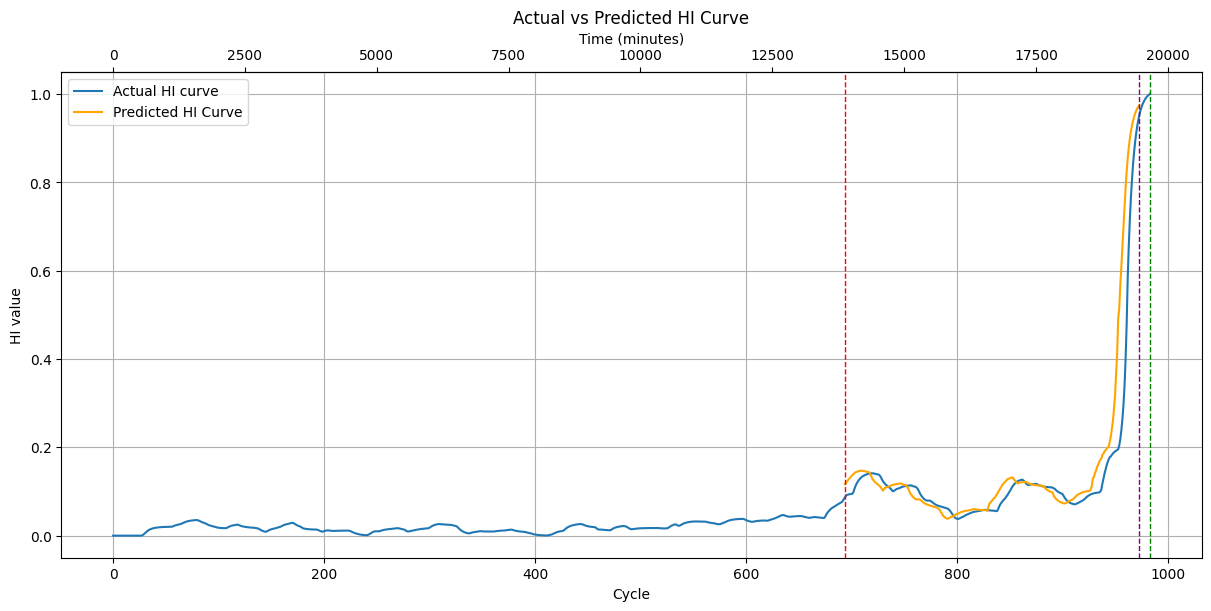

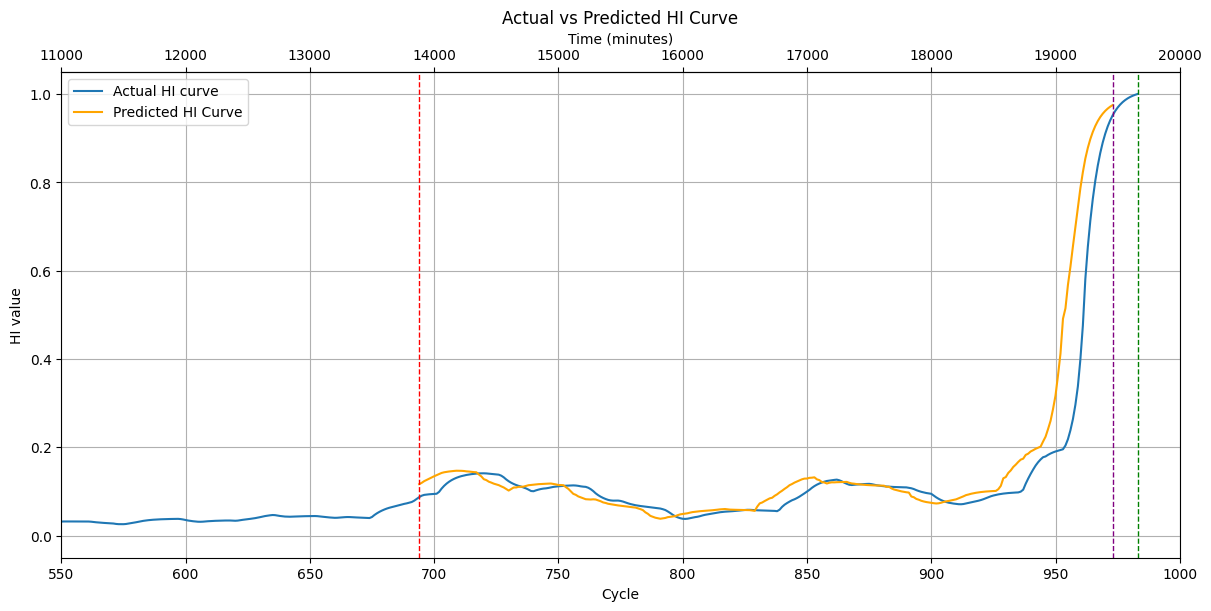

Error: 3.4602076124567476
Predicted RUL(minutes): 5580
Actual RUL (minutes): 5780
Predicted RUL (cycle): 973
Actual RUL (cycle): 983


In [15]:
plot_test_preds_double_axis(df_train, TRAIN_SIZE, train_test, rul_pred_idx, rul_actual_idx, 1200, "predicted_curve_train.pdf")
plot_test_preds_double_axis(df_train, TRAIN_SIZE, train_test, rul_pred_idx, rul_actual_idx, 1200, "predicted_curve_train_zoomed.pdf", zoom=True, xmin=550, xmax=1000)
print(f"Error: {error(rul_actual_idx, rul_pred_idx, TRAIN_SIZE)}")

rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, TRAIN_SIZE, 20)
print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

print(f"Predicted RUL (cycle): {rul_pred_idx}")
print(f"Actual RUL (cycle): {rul_actual_idx}")

In [16]:
df_IMS_no3 = pd.read_pickle("../hi_curves/hicurvebearing3test3.pkl")

X, y = df_to_X_y(df_IMS_no3, SEQUENCE_LENGTH)
X.shape, y.shape

test_starting_from = 6157

In [17]:
X_test, y_test = X[test_starting_from:], y[test_starting_from:]

In [18]:
IMS_no3_preds = model.predict(X_test).flatten()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


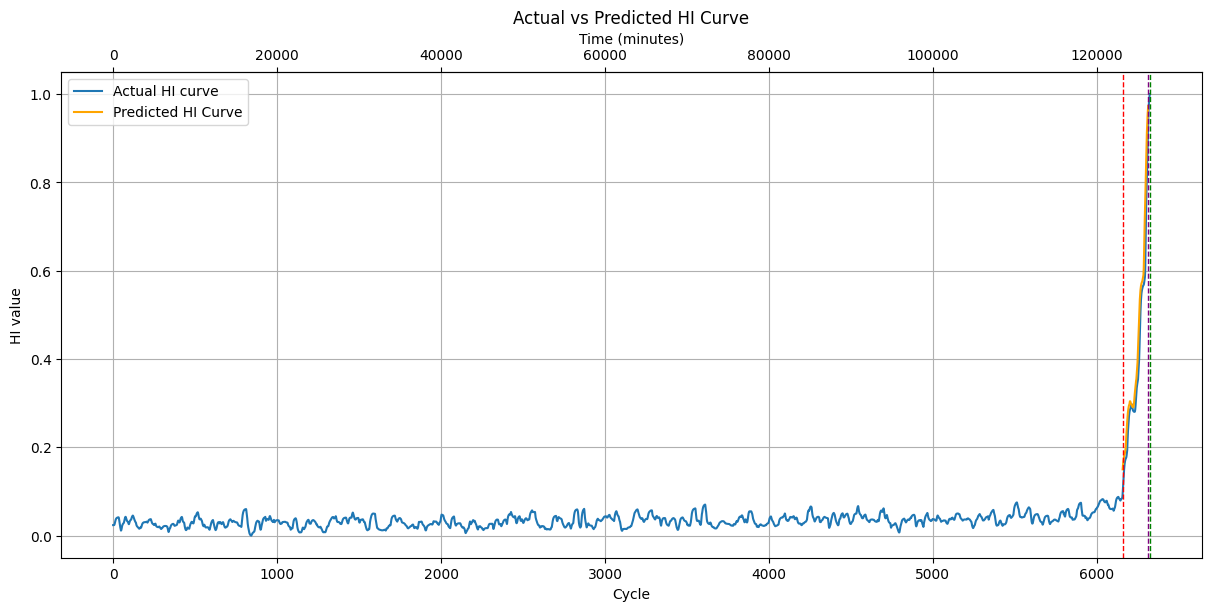

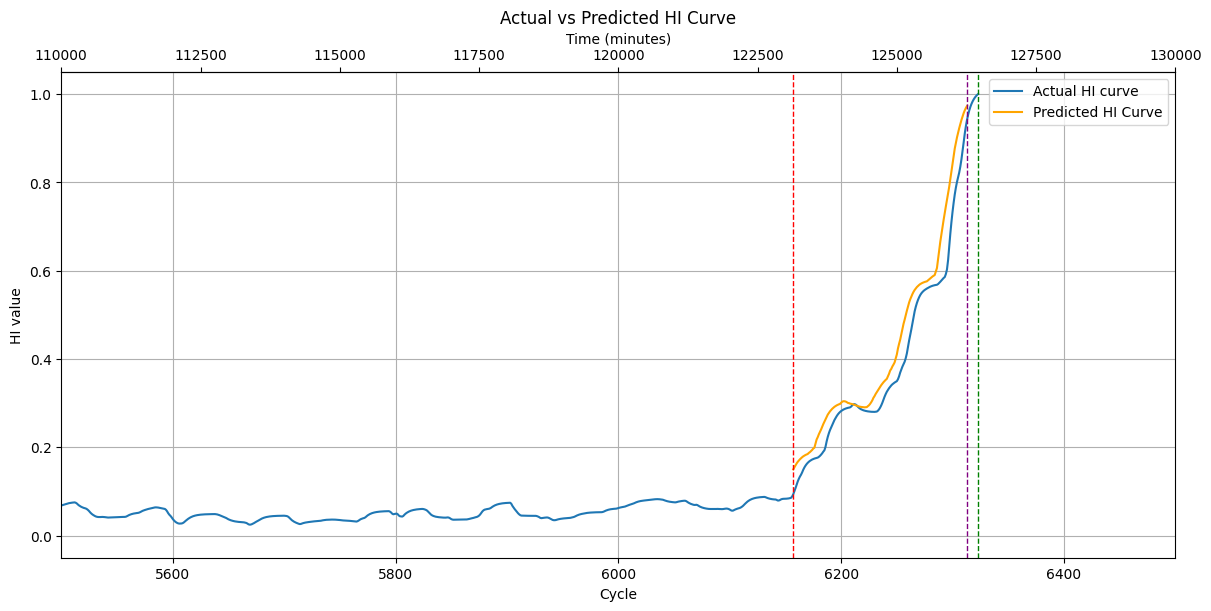

Error: 6.024096385542169
Predicted RUL(minutes): 3120
Actual RUL (minutes): 3320
Predicted RUL (cycle): 6313
Actual RUL (cycle): 6323
RMSE: 0.021113682715031862


In [19]:
rul_pred_idx, _ = find_closest_to_one(IMS_no3_preds, test_starting_from)
rul_actual_idx, _ = find_closest_to_one(df_IMS_no3.to_numpy())

# plot_test_predictions(df_IMS_no3, test_starting_from, IMS_no3_preds, rul_pred_idx, rul_actual_idx, "predicted_curve_IMS_n03.pdf")
# plot_zoomed(df_IMS_no3, test_starting_from, IMS_no3_preds, rul_pred_idx, rul_actual_idx, "predicted_curve_IMS_n03_zoomed.pdf", 5500, 6500)
plot_test_preds_double_axis(df_IMS_no3, test_starting_from, IMS_no3_preds, rul_pred_idx, rul_actual_idx, 1200, "predicted_curve_IMS_n03.pdf")
plot_test_preds_double_axis(df_IMS_no3, test_starting_from, IMS_no3_preds, rul_pred_idx, rul_actual_idx, 1200, "predicted_curve_IMS_n03_zoomed.pdf", zoom=True, xmin=5500, xmax=6500)

print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, 20)
print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

print(f"Predicted RUL (cycle): {rul_pred_idx}")
print(f"Actual RUL (cycle): {rul_actual_idx}")

rmse = np.sqrt(mean_squared_error(y_test, IMS_no3_preds))
print(f"RMSE: {rmse}")

In [20]:
# df_FEMTO_Bearing1_3_horizontal = pd.read_pickle("../hi_curves/hicurve_FEMTO_Bearing1_3_horizontal.pkl")

# X, y = df_to_X_y(df_FEMTO_Bearing1_3_horizontal, SEQUENCE_LENGTH)
# X.shape, y.shape

# test_starting_from = 1762
# X_test, y_test = X[test_starting_from:], y[test_starting_from:]
# FEMTO_Bearing1_3_horizontal_preds = model.predict(X_test).flatten()

# rul_pred_idx, _ = find_closest_to_one(FEMTO_Bearing1_3_horizontal_preds, test_starting_from)
# rul_actual_idx, _ = find_closest_to_one(df_FEMTO_Bearing1_3_horizontal.to_numpy())

# plot_test_preds_double_axis(df_FEMTO_Bearing1_3_horizontal, test_starting_from, FEMTO_Bearing1_3_horizontal_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_3_horizontal.pdf")
# plot_test_preds_double_axis(df_FEMTO_Bearing1_3_horizontal, test_starting_from, FEMTO_Bearing1_3_horizontal_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_3_horizontal_zoomed.pdf", zoom=True, xmin=1500, xmax=2400)


# print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

# rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, (10/60))
# print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
# print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

# print(f"Predicted RUL (cycle): {rul_pred_idx}")
# print(f"Actual RUL (cycle): {rul_actual_idx}")

In [21]:
# df_FEMTO_Bearing1_4_horizontal = pd.read_pickle("../hi_curves/hicurve_FEMTO_Bearing1_4_horizontal.pkl")

# X, y = df_to_X_y(df_FEMTO_Bearing1_4_horizontal, SEQUENCE_LENGTH)
# X.shape, y.shape

# test_starting_from = 1083
# X_test, y_test = X[test_starting_from:], y[test_starting_from:]
# FEMTO_Bearing1_4_horizontal_preds = model.predict(X_test).flatten()

# rul_pred_idx, _ = find_closest_to_one(FEMTO_Bearing1_4_horizontal_preds, test_starting_from)
# rul_actual_idx, _ = find_closest_to_one(df_FEMTO_Bearing1_4_horizontal.to_numpy())

# # plot_test_predictions(df_FEMTO_Bearing1_4_horizontal, test_starting_from, FEMTO_Bearing1_4_horizontal_preds, rul_pred_idx, rul_actual_idx, "predicted_curve_FEMTO_Bearing1_4_horizontal.pdf")
# # plot_zoomed(df_FEMTO_Bearing1_4_horizontal, test_starting_from, FEMTO_Bearing1_4_horizontal_preds, rul_pred_idx, rul_actual_idx, "predicted_curve_FEMTO_Bearing1_4_horizontal_zoomed.pdf", 1000, 1450)
# # plot_test_preds_double_axis(df_FEMTO_Bearing1_4_horizontal, test_starting_from, FEMTO_Bearing1_4_horizontal_preds, rul_pred_idx, rul_actual_idx, 10, "test.pdf")
# plot_test_preds_double_axis(df_FEMTO_Bearing1_4_horizontal, test_starting_from, FEMTO_Bearing1_4_horizontal_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_4_horizontal.pdf")
# plot_test_preds_double_axis(df_FEMTO_Bearing1_4_horizontal, test_starting_from, FEMTO_Bearing1_4_horizontal_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_4_horizontal.pdf", zoom=True, xmin=1000, xmax=1450)


# print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

# rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, (10/60))
# print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
# print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

# print(f"Predicted RUL (cycle): {rul_pred_idx}")
# print(f"Actual RUL (cycle): {rul_actual_idx}")

In [22]:
# df_FEMTO_Bearing1_7_vertical = pd.read_pickle("../hi_curves/hicurve_FEMTO_Bearing1_7_vertical.pkl")

# X, y = df_to_X_y(df_FEMTO_Bearing1_7_vertical, SEQUENCE_LENGTH)
# X.shape, y.shape

# test_starting_from = 1001
# X_test, y_test = X[test_starting_from:], y[test_starting_from:]
# FEMTO_Bearing1_7_vertical_preds = model.predict(X_test).flatten()

# rul_pred_idx, _ = find_closest_to_one(FEMTO_Bearing1_7_vertical_preds, test_starting_from)
# rul_actual_idx, _ = find_closest_to_one(df_FEMTO_Bearing1_7_vertical.to_numpy())

# plot_test_preds_double_axis(df_FEMTO_Bearing1_7_vertical, test_starting_from, FEMTO_Bearing1_7_vertical_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_7_vertical.pdf")
# plot_test_preds_double_axis(df_FEMTO_Bearing1_7_vertical, test_starting_from, FEMTO_Bearing1_7_vertical_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_7_vertical_zoomed.pdf", zoom=True, xmin=950, xmax=2280)

# print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

# rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, (10/60))
# print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
# print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

# print(f"Predicted RUL (cycle): {rul_pred_idx}")
# print(f"Actual RUL (cycle): {rul_actual_idx}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


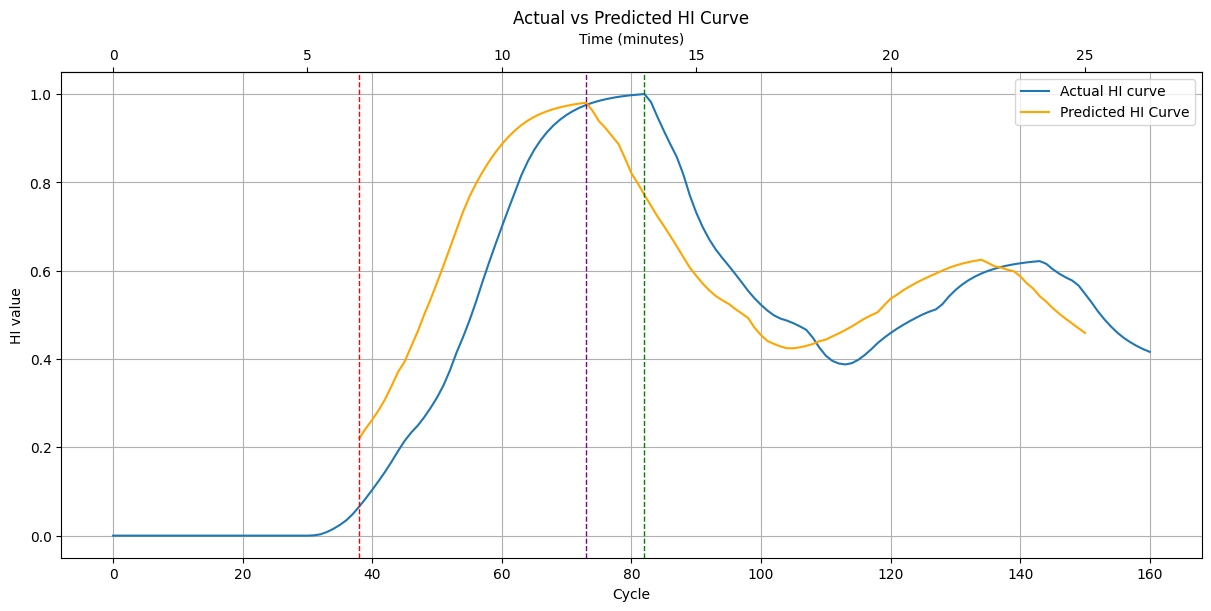

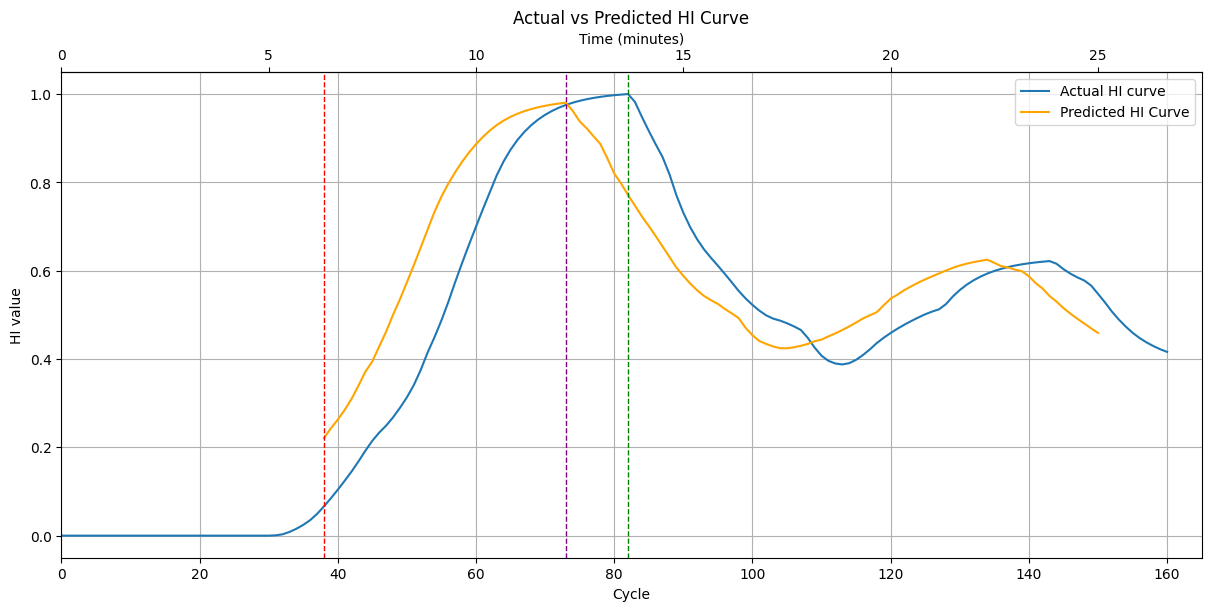

Error: 20.454545454545457
Predicted RUL(minutes): 35
Actual RUL (minutes): 44
Predicted RUL (cycle): 73
Actual RUL (cycle): 82
RMSE: 0.05891817767548779


In [23]:
df_XJTU_SY_Bearing1_2_combined = pd.read_pickle("../hi_curves/hicurve_XJTU-SY_Bearing1_2_combined.pkl")

X, y = df_to_X_y(df_XJTU_SY_Bearing1_2_combined, SEQUENCE_LENGTH)
X.shape, y.shape

test_starting_from = 38
X_test, y_test = X[test_starting_from:], y[test_starting_from:]
XJTU_SY_Bearing1_2_combined_preds = model.predict(X_test).flatten()

rul_pred_idx, _ = find_closest_to_one(XJTU_SY_Bearing1_2_combined_preds, test_starting_from)
rul_actual_idx, _ = find_closest_to_one(df_XJTU_SY_Bearing1_2_combined.to_numpy())

plot_test_preds_double_axis(df_XJTU_SY_Bearing1_2_combined, test_starting_from, XJTU_SY_Bearing1_2_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_XJTU-SY_Bearing1_2_combined.pdf")
plot_test_preds_double_axis(df_XJTU_SY_Bearing1_2_combined, test_starting_from, XJTU_SY_Bearing1_2_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_XJTU-SY_Bearing1_2_combined_zoomed.pdf", zoom=True, xmin=0, xmax=165)

print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, 1)
print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

print(f"Predicted RUL (cycle): {rul_pred_idx}")
print(f"Actual RUL (cycle): {rul_actual_idx}")

rmse = np.sqrt(mean_squared_error(y_test, XJTU_SY_Bearing1_2_combined_preds))
print(f"RMSE: {rmse}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


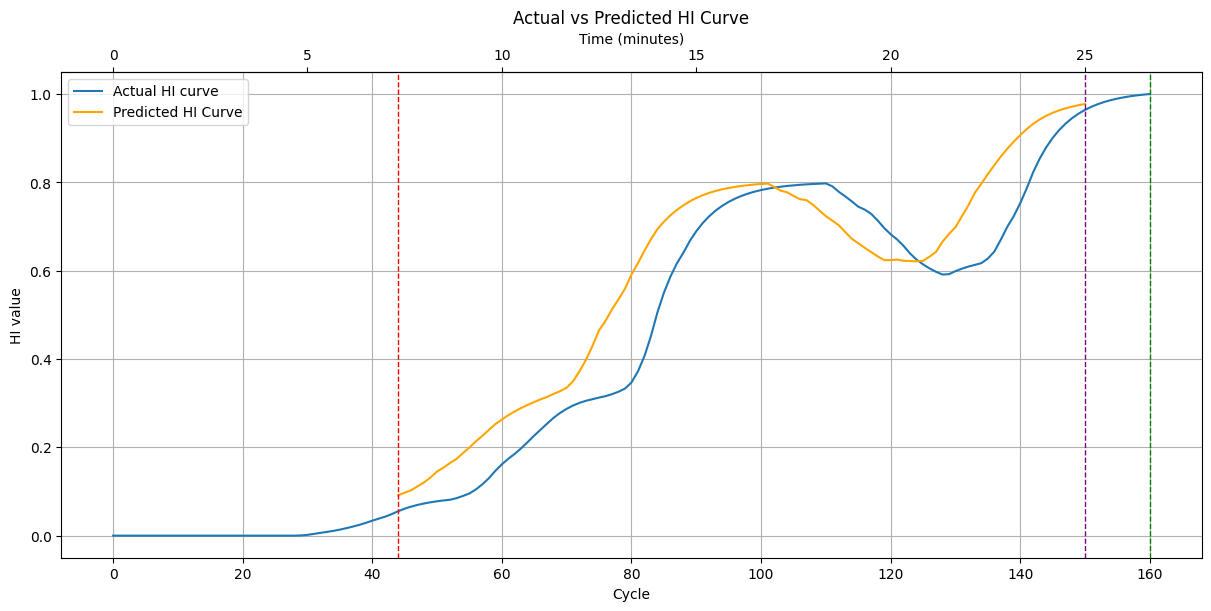

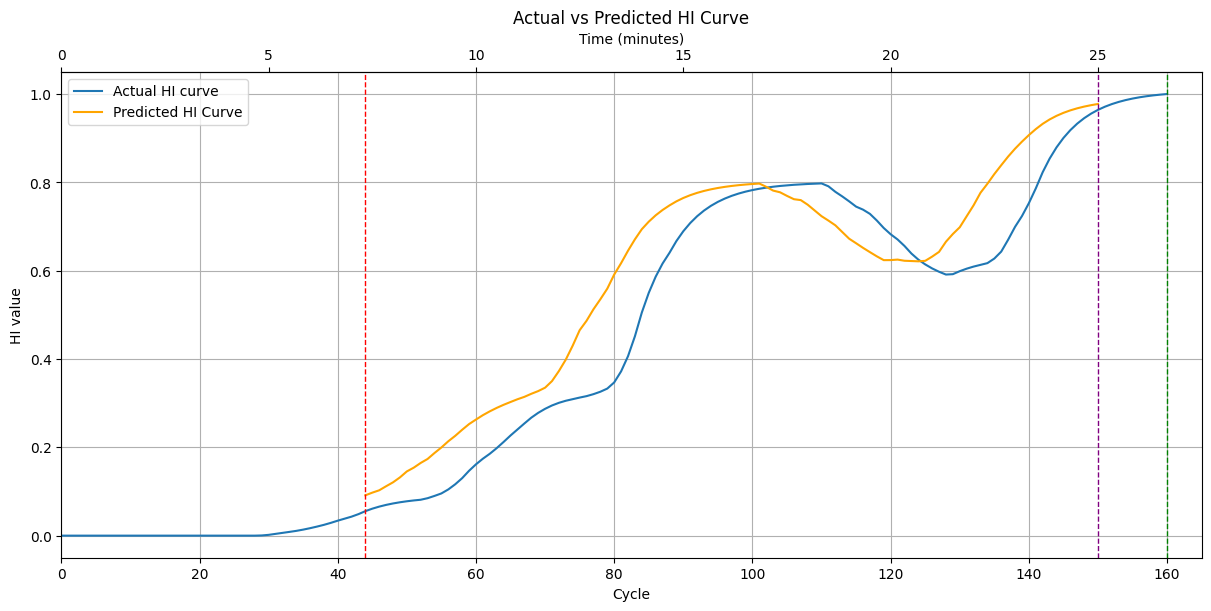

Error: 8.620689655172415
Predicted RUL(minutes): 106
Actual RUL (minutes): 116
Predicted RUL (cycle): 150
Actual RUL (cycle): 160
RMSE: 0.04373320735302296


In [24]:
df_XJTU_SY_Bearing2_2_combined = pd.read_pickle("../hi_curves/hicurve_XJTU-SY_Bearing2_2_combined.pkl")

X, y = df_to_X_y(df_XJTU_SY_Bearing2_2_combined, SEQUENCE_LENGTH)
X.shape, y.shape

test_starting_from = 44
X_test, y_test = X[test_starting_from:], y[test_starting_from:]
XJTU_SY_Bearing2_2_combined_preds = model.predict(X_test).flatten()

rul_pred_idx, _ = find_closest_to_one(XJTU_SY_Bearing2_2_combined_preds, test_starting_from)
rul_actual_idx, _ = find_closest_to_one(df_XJTU_SY_Bearing2_2_combined.to_numpy())

plot_test_preds_double_axis(df_XJTU_SY_Bearing2_2_combined, test_starting_from, XJTU_SY_Bearing2_2_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_XJTU-SY_Bearing2_2_combined.pdf")
plot_test_preds_double_axis(df_XJTU_SY_Bearing2_2_combined, test_starting_from, XJTU_SY_Bearing2_2_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_XJTU-SY_Bearing2_2_combined_zoomed.pdf", zoom=True, xmin=0, xmax=165)

print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, 1)
print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

print(f"Predicted RUL (cycle): {rul_pred_idx}")
print(f"Actual RUL (cycle): {rul_actual_idx}")

rmse = np.sqrt(mean_squared_error(y_test, XJTU_SY_Bearing2_2_combined_preds))
print(f"RMSE: {rmse}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
96
105


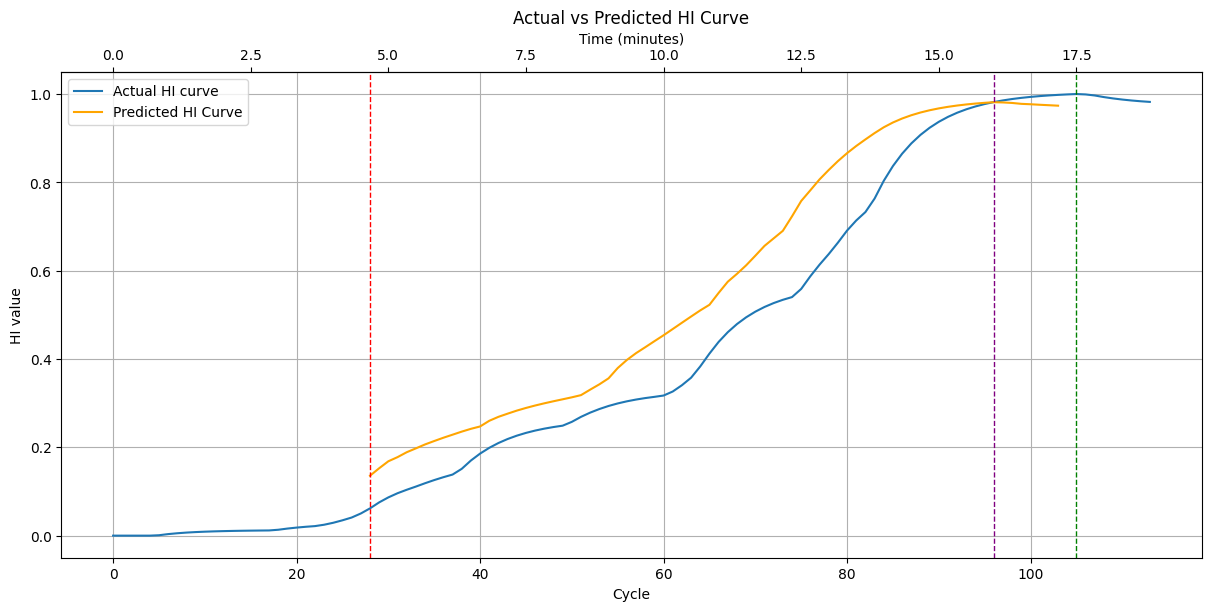

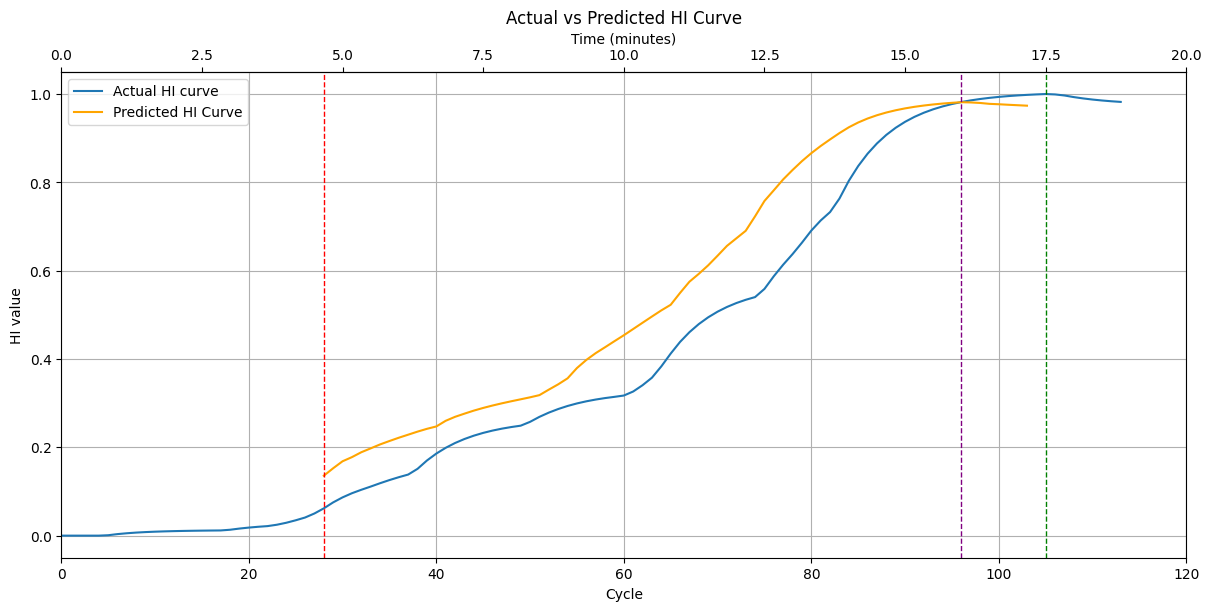

Error: 11.688311688311687
Predicted RUL(minutes): 68
Actual RUL (minutes): 77
Predicted RUL (cycle): 96
Actual RUL (cycle): 105
RMSE: 0.039214069977675306


In [25]:
df_XJTU_SY_Bearing3_5_combined = pd.read_pickle("../hi_curves/hicurve_XJTU-SY_Bearing3_5_combined.pkl")

X, y = df_to_X_y(df_XJTU_SY_Bearing3_5_combined, SEQUENCE_LENGTH)
X.shape, y.shape

test_starting_from = 28
X_test, y_test = X[test_starting_from:], y[test_starting_from:]
XJTU_SY_Bearing3_5_combined_preds = model.predict(X_test).flatten()

rul_pred_idx, _ = find_closest_to_one(XJTU_SY_Bearing3_5_combined_preds, test_starting_from)
rul_actual_idx, _ = find_closest_to_one(df_XJTU_SY_Bearing3_5_combined.to_numpy())
print(rul_pred_idx)
print(rul_actual_idx)

plot_test_preds_double_axis(df_XJTU_SY_Bearing3_5_combined, test_starting_from, XJTU_SY_Bearing3_5_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_XJTU-SY_Bearing3_5_combined.pdf")
plot_test_preds_double_axis(df_XJTU_SY_Bearing3_5_combined, test_starting_from, XJTU_SY_Bearing3_5_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_XJTU-SY_Bearing3_5_combined_zoomed.pdf", zoom=True, xmin=0, xmax=120)

print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, 1)
print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

print(f"Predicted RUL (cycle): {rul_pred_idx}")
print(f"Actual RUL (cycle): {rul_actual_idx}")

rmse = np.sqrt(mean_squared_error(y_test, XJTU_SY_Bearing3_5_combined_preds))
print(f"RMSE: {rmse}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


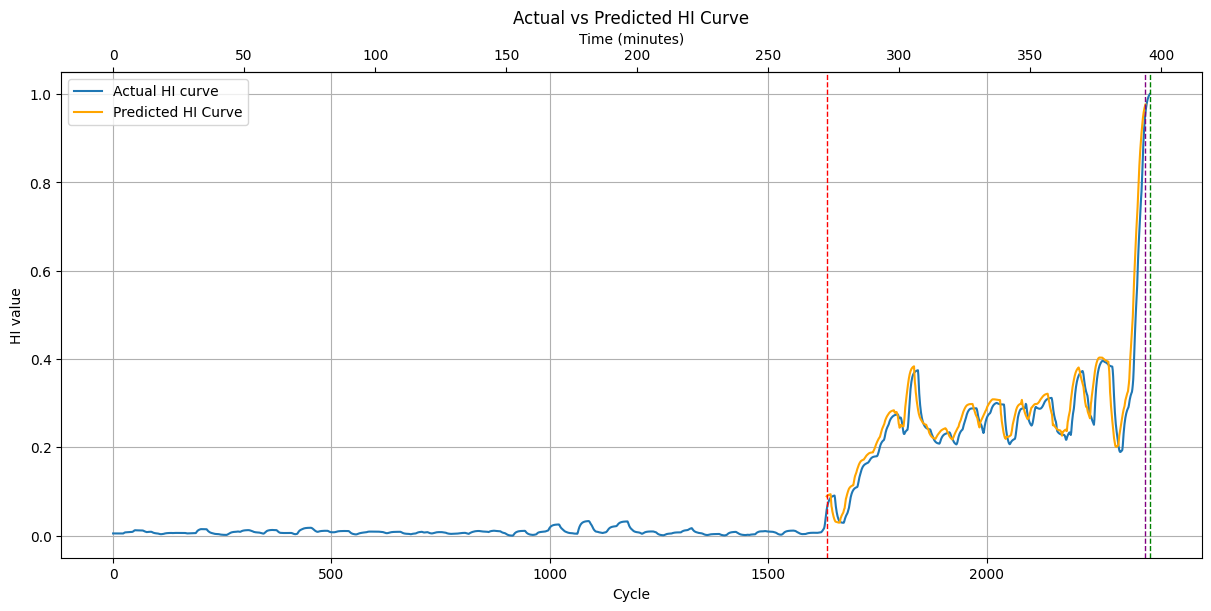

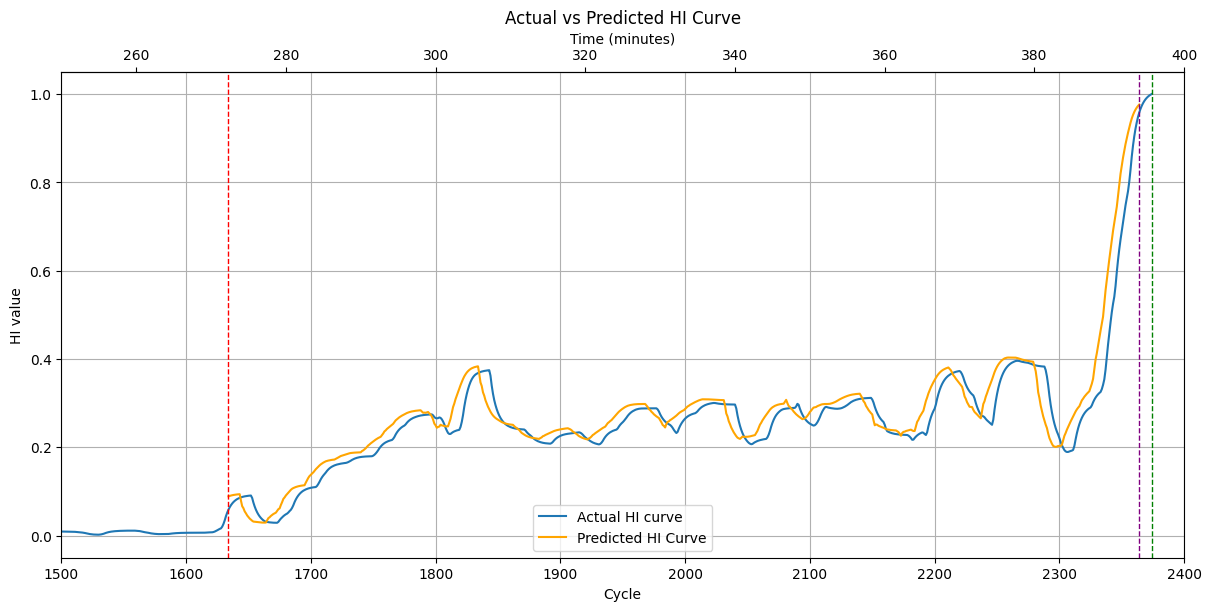

Error: 1.3513513513513513
Predicted RUL(minutes): 121.66666666666666
Actual RUL (minutes): 123.33333333333333
Predicted RUL (cycle): 2364
Actual RUL (cycle): 2374
RMSE: 0.016831419506770157


In [26]:
df_FEMTO_Bearing1_3_combined = pd.read_pickle("../hi_curves/hicurve_FEMTO_Bearing1_3_combined.pkl")

X, y = df_to_X_y(df_FEMTO_Bearing1_3_combined, SEQUENCE_LENGTH)
X.shape, y.shape

test_starting_from = 1634
X_test, y_test = X[test_starting_from:], y[test_starting_from:]
FEMTO_Bearing1_3_combined_preds = model.predict(X_test).flatten()

rul_pred_idx, _ = find_closest_to_one(FEMTO_Bearing1_3_combined_preds, test_starting_from)
rul_actual_idx, _ = find_closest_to_one(df_FEMTO_Bearing1_3_combined.to_numpy())

plot_test_preds_double_axis(df_FEMTO_Bearing1_3_combined, test_starting_from, FEMTO_Bearing1_3_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_3_combined.pdf")
plot_test_preds_double_axis(df_FEMTO_Bearing1_3_combined, test_starting_from, FEMTO_Bearing1_3_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_3_combined_zoomed.pdf", zoom=True, xmin=1500, xmax=2400)

print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, (10/60))
print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

print(f"Predicted RUL (cycle): {rul_pred_idx}")
print(f"Actual RUL (cycle): {rul_actual_idx}")

rmse = np.sqrt(mean_squared_error(y_test, FEMTO_Bearing1_3_combined_preds))
print(f"RMSE: {rmse}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


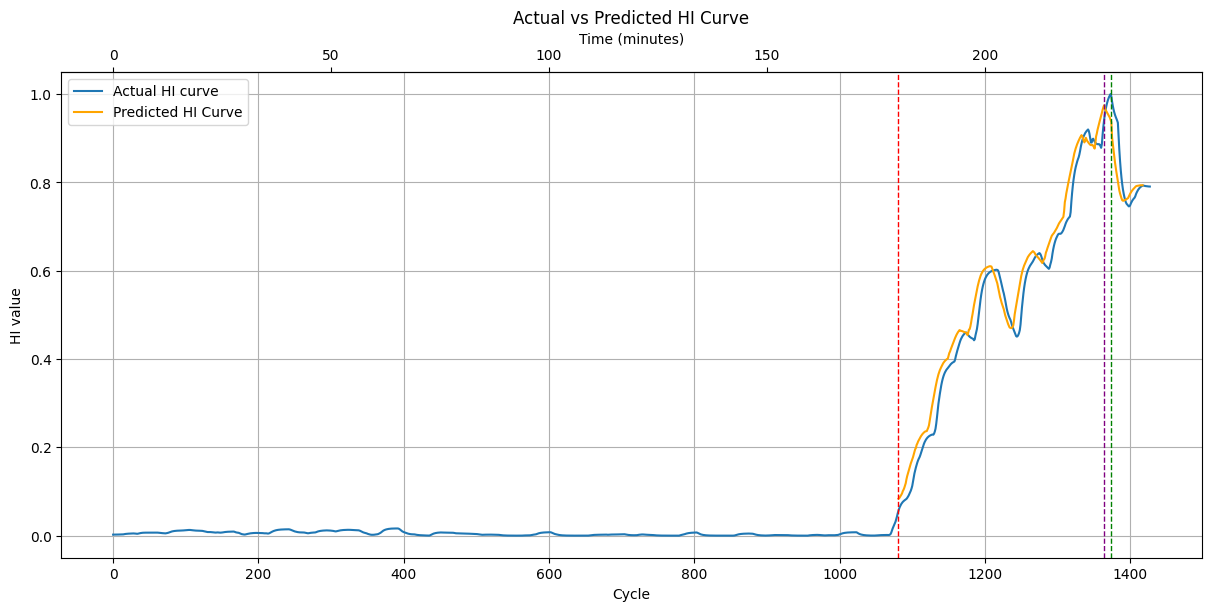

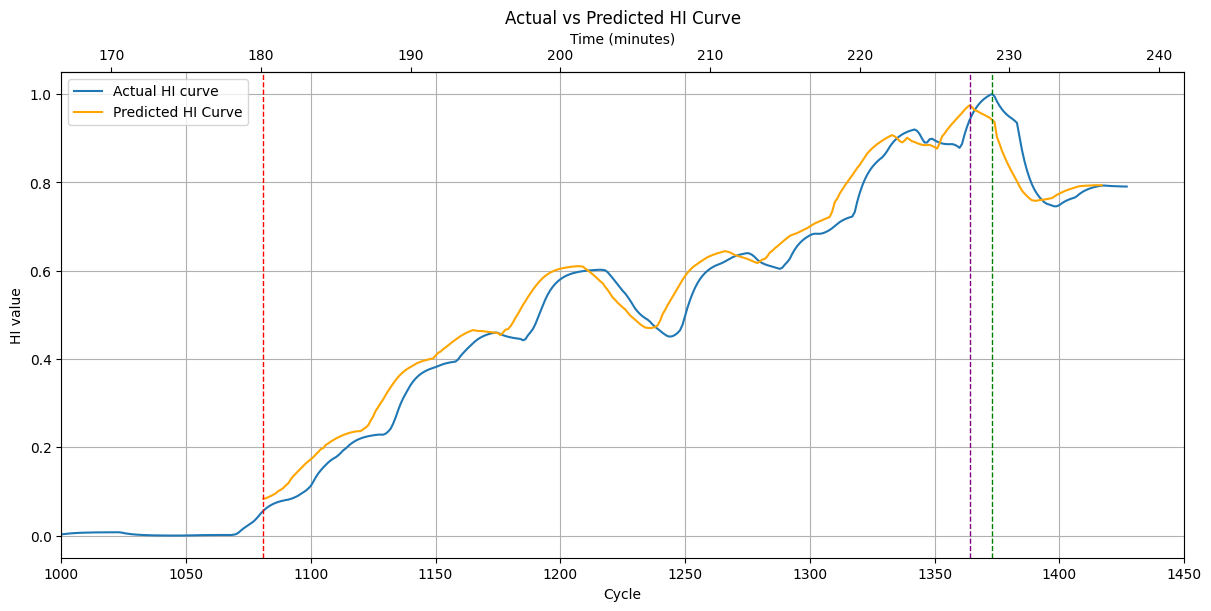

Error: 3.0821917808219177
Predicted RUL(minutes): 47.166666666666664
Actual RUL (minutes): 48.666666666666664
Predicted RUL (cycle): 1364
Actual RUL (cycle): 1373
RMSE: 0.016851353544882836


In [27]:
df_FEMTO_Bearing1_4_combined = pd.read_pickle("../hi_curves/hicurve_FEMTO_Bearing1_4_combined.pkl")

X, y = df_to_X_y(df_FEMTO_Bearing1_4_combined, SEQUENCE_LENGTH)
X.shape, y.shape

test_starting_from = 1081
X_test, y_test = X[test_starting_from:], y[test_starting_from:]
FEMTO_Bearing1_4_combined_preds = model.predict(X_test).flatten()

rul_pred_idx, _ = find_closest_to_one(FEMTO_Bearing1_4_combined_preds, test_starting_from)
rul_actual_idx, _ = find_closest_to_one(df_FEMTO_Bearing1_4_combined.to_numpy())

plot_test_preds_double_axis(df_FEMTO_Bearing1_4_combined, test_starting_from, FEMTO_Bearing1_4_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_4_combined.pdf")
plot_test_preds_double_axis(df_FEMTO_Bearing1_4_combined, test_starting_from, FEMTO_Bearing1_4_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_4_combined_zoomed.pdf", zoom=True, xmin=1000, xmax=1450)


print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, (10/60))
print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

print(f"Predicted RUL (cycle): {rul_pred_idx}")
print(f"Actual RUL (cycle): {rul_actual_idx}")

rmse = np.sqrt(mean_squared_error(y_test, FEMTO_Bearing1_4_combined_preds))
print(f"RMSE: {rmse}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


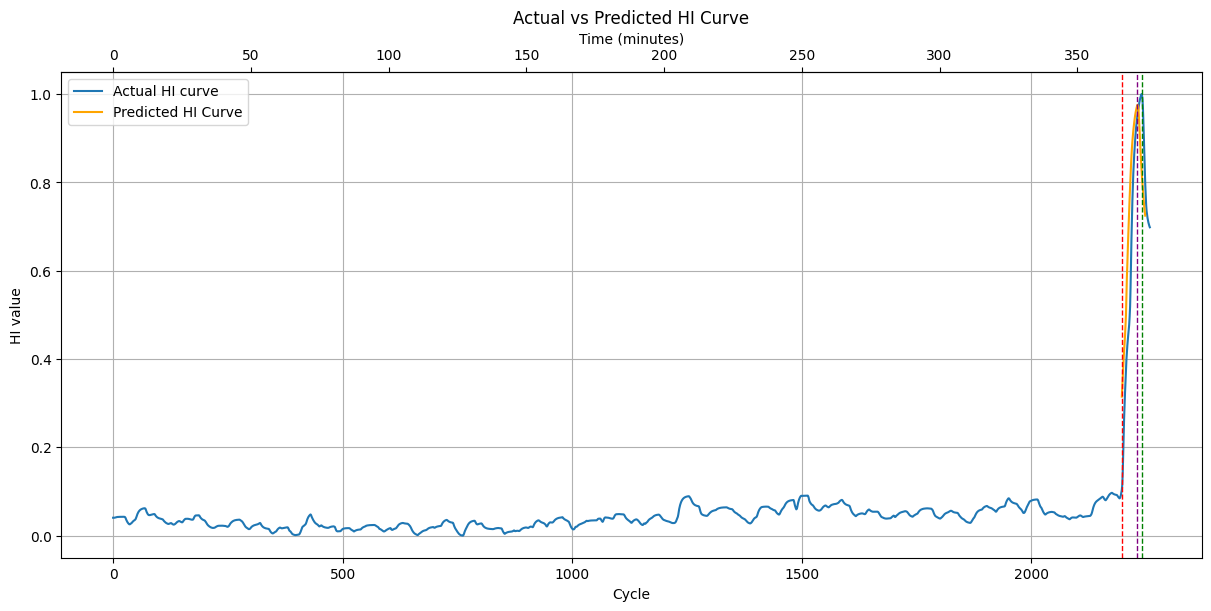

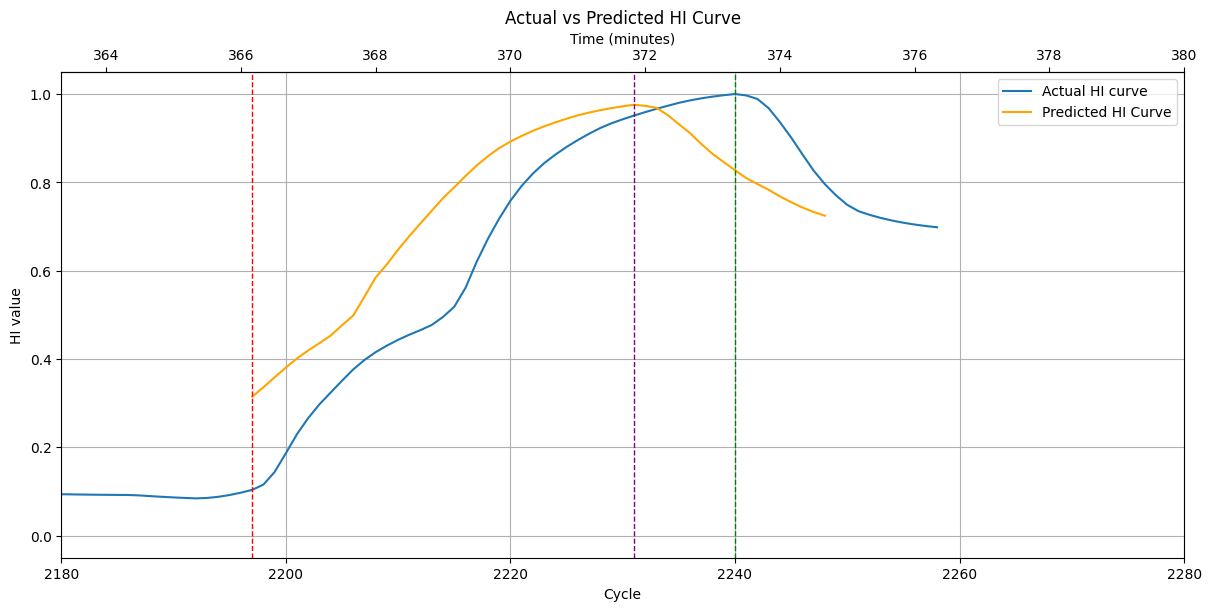

Error: 20.930232558139537
Predicted RUL(minutes): 5.666666666666666
Actual RUL (minutes): 7.166666666666666
Predicted RUL (cycle): 2231
Actual RUL (cycle): 2240
RMSE: 0.06359249220941691


In [28]:
df_FEMTO_Bearing1_7_combined = pd.read_pickle("../hi_curves/hicurve_FEMTO_Bearing1_7_combined.pkl")

X, y = df_to_X_y(df_FEMTO_Bearing1_7_combined, SEQUENCE_LENGTH)
X.shape, y.shape

test_starting_from = 2197
X_test, y_test = X[test_starting_from:], y[test_starting_from:]
FEMTO_Bearing1_7_combined_preds = model.predict(X_test).flatten()

rul_pred_idx, _ = find_closest_to_one(FEMTO_Bearing1_7_combined_preds, test_starting_from)
rul_actual_idx, _ = find_closest_to_one(df_FEMTO_Bearing1_7_combined.to_numpy())

plot_test_preds_double_axis(df_FEMTO_Bearing1_7_combined, test_starting_from, FEMTO_Bearing1_7_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_7_combined.pdf")
plot_test_preds_double_axis(df_FEMTO_Bearing1_7_combined, test_starting_from, FEMTO_Bearing1_7_combined_preds, rul_pred_idx, rul_actual_idx, 10, "predicted_curve_FEMTO_Bearing1_7_combined_zoomed.pdf", zoom=True, xmin=2180, xmax=2280)

print(f"Error: {error(rul_actual_idx, rul_pred_idx, test_starting_from)}")

rul_predicted_in_minutes, rul_actual_in_minutes = rul_in_minutes(rul_actual_idx, rul_pred_idx, test_starting_from, (10/60))
print(f"Predicted RUL(minutes): {rul_predicted_in_minutes}")
print(f"Actual RUL (minutes): {rul_actual_in_minutes}")

print(f"Predicted RUL (cycle): {rul_pred_idx}")
print(f"Actual RUL (cycle): {rul_actual_idx}")

rmse = np.sqrt(mean_squared_error(y_test, FEMTO_Bearing1_7_combined_preds))
print(f"RMSE: {rmse}")